ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 5

Тема: Уменьшение размерности

Группа: ПИН-б-о-22-1

Выполнил: Касимов Асхаб


#  Импорт данных


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.datasets import fetch_openml

In [2]:
plt.style.use('dark_background')

## Метод главных компонент


Метод главных компонент - это метод снижения размерности данных путем преобразования их в такую форму, чтобы оставить только максимально полезную информацию. Метод работает без учителя, поэтому под термином полезная информация в данном методе понимается набор независимых друг от друга признаков с максимальной дисперсией (с максимальным разбросом значений). При этом мы изначально полагаем, что интенсивность (в некотором смысле) полезной информации преобладает над интенсивностью каких-то случайных искажений или других не идеальностей нашего набора данных. Для выделения полезной информации в методе главных компонент проводится преобразование данных от набора исходных столбцов (исходных признаков), которые могут содержать шумы и быть линейно зависимыми к набору новых столбцов, которые обладают важным свойством линейной независимости (не коррелируют). Такие новые столбцы можно изобразить как некоторую систему координат, в которых можно отложить точки - наши данные. При этом часто оказывает так, что некоторые из координат не нужны - в них почти наверняка нет информации. Это можно представить, как если мы возьмём двухмерную фигуры и будем строить ее в трехмерной плоскости. При этом окажется, что можно выбрать такую систему координат, что третья ось не нужна. При этом даже если мы возьмём трехмерную цельную фигуры, но по одной из осей у нас будет "совсем чуть-чуть", то можно рассмотреть этот случай как двухмерный. В нашем примере две оси, в которых будет основная часть фигуры будут главными компонентами. Совокупность наших главных компонент образует т.н. собственное подпространство. Третья ось останется т.н. шумовым подпространством. Как видно из примера размерность фигуры в каждой из обозначенных осей будет соответствовать важности этой оси. Другими словами, можно сказать что разброс значений в каждой оси будет соответствовать ее важности. Такой разброс значений по каждой оси будет называться - собственные значения. Сортируя собственные значения по убыванию, мы можем определить те из них, которые следует оставить и те, которые следует убрать. Цель Метода Главных компонент найти и отбросить шумовое подпространство.

Классический метод главных компонент состоит из следующих операций:
1.	вычисление ковариационной матрицы для набора данных - то есть матрицу дисперсий.
2.	вычисление (поиск) собственных векторов и их собственных значений по ковариационной матрице.
3.	сортировка собственных значений по убыванию.
4.	выделения собственного подпространства.
5.	преобразование данных - построение проекции исходного массива на полученные собственные вектора.

1-4 операции будут реализованы функцией `fit` последняя операция будет реализована функцией `transform`. Также нами будет реализована операция `inverse_transform`, необходимая для восстоновления исходного набора данных. Важно отметить, что на практике такое восстановление может быть не точным так как сокращая разность данных вы можете удалить оттуда и часть полезной информации. Оценку точности восстоновления можно провести по метрике $R_2$, которая обсуждалась выше.

Отметим, что известно, что собственные вектора и собственные значения для некоторой квадратной матрицы $A$ удовлетворяют следующему уравнению:
$$A\vec{V}_i = \lambda_i\vec{V}_i,$$
где $\vec{V}_i$ - это собственный вектор; $\lambda_i$ - соответствующее собственное значение. По сути выражение выше представляет собой решение системы линейных уравнений с параметром $\lambda_i$. Значения данного параметра можно найти из следующего выражения:
$$ det(A-\lambda_I) = 0, $$
где $det$ - операция поиска определителя матрицы, а $\lambda_I$ - диагональная матрица с собственными значениями по главной диагонали и нулями в остальных позициях. При раскрытие операции детерменент по определению данное уравнение может быть сведено к поиску корней полнинома.





In [15]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None

    #--------------------------------
    def fit(self, X):

        self.mean = np.mean(X, axis=0)

        # Считаем матрицу ковариации
        cov_matrix = np.cov(X - self.mean, rowvar = False)

        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        idx = eigenvalues.argsort()[::-1] #Сортируем по возрастанию

        # Берём первые n главных компонент
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx]

        return self

    #--------------------------------
    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components)
    #--------------------------------
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    #--------------------------------
    def inverse_transform(self, X_new):
        return np.dot(X_new, self.components.T) + self.mean
    #--------------------------------
    def score(self, X):
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    #--------------------------------
    def plot_eigvalues(self, figsize=(15,7)):
        plt.figure(figsize=figsize)
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное Пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(FontSize = 25); plt.yticks(FontSize = 25);
        plt.tight_layout();



# Синтетические данные

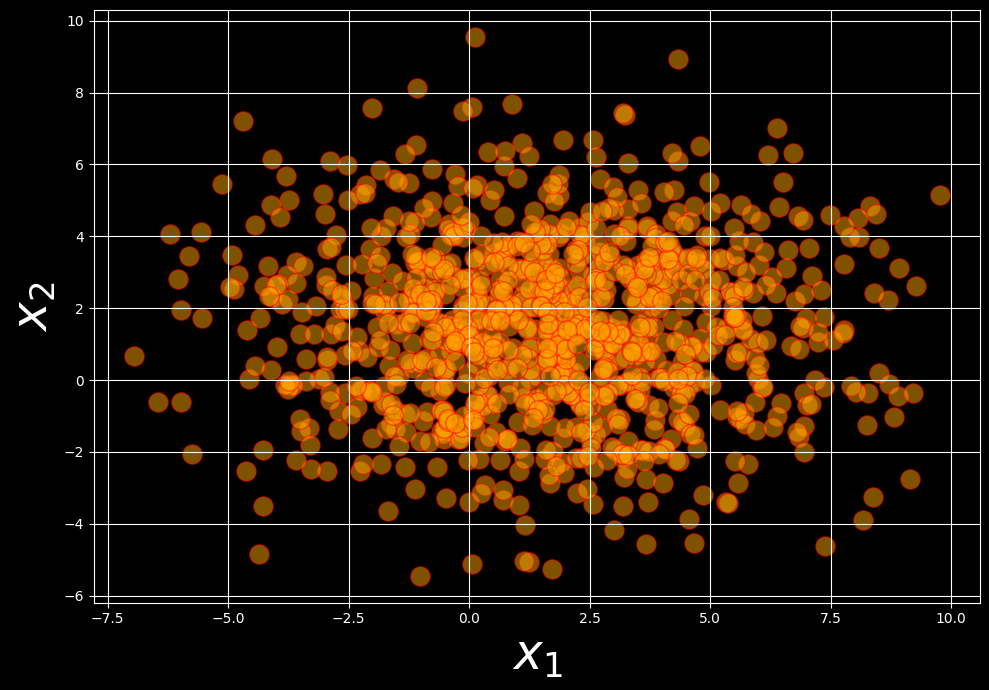

In [25]:
#@title **Параметры распределения данных** { run: "auto" }
#@markdown ### Координаты Центра
C1 =  1.5 #@param {type:"slider", min:-5, max:5, step:0.1}
C2 =  1.5 #@param {type:"slider", min:-5, max:5, step:0.1}
#@markdown ### "Мощность" направлений
S1 =  2.5 #@param {type:"slider", min:0, max:5, step:0.1}
S2 =  2.9 #@param {type:"slider", min:0, max:5, step:0.1}
#@markdown ### Угол наклона
theta = 1.9 #@param {type:"slider", min:0.1, max:12, step:0.1}
#@markdown ### Количество точек
N = 1000 #@param {type:"slider", min:100, max:2000, step:100}

theta = np.pi/theta
Centers = np.array([C1,C2])
Sigmas = np.array([S1,S2])

# Матрица поворота
R = np.array([[np.cos(theta), - np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])

X = R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers)@ np.ones((2, N))

fig = plt.figure(figsize=(10,7))
plt.grid()

plt.scatter(X[0,:],X[1:],
            alpha = 0.5, s = 196,
            c = 'orange', edgecolor = 'r')
plt.xlabel(r'$x_1$',fontsize=35)
plt.ylabel(r'$x_2$',fontsize=35)


plt.tight_layout();

In [26]:
def create_elipsoid_data(C1 = 0,C2 = 0 ,S1 = 5,S2 =1, theta =45, N = 250, random_state = 42):
    np.random.seed(random_state)

    theta = np.pi*theta/180
    Centers = np.array([C1,C2])
    Sigmas = np.array([S1,S2])

    R = np.array([[np.cos(theta), - np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])

    return (R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers)@ np.ones((2, N))).T


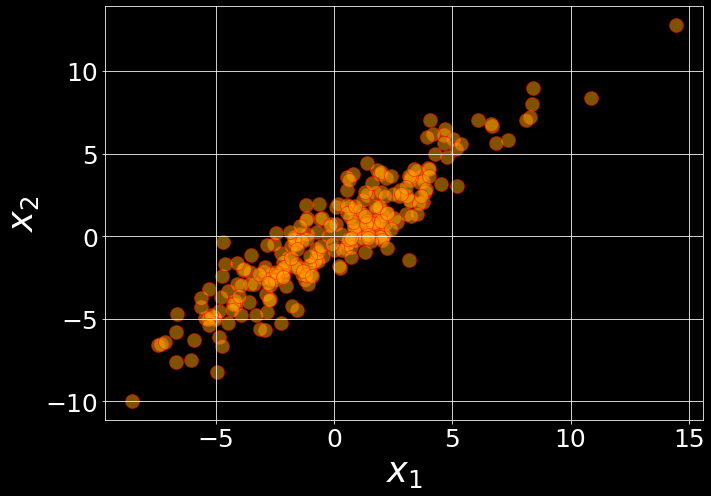

In [ ]:
X =create_elipsoid_data()


fig  = plt.figure(figsize=(10,7))
plt.scatter(X[:, 0],X[:, 1],
            alpha = 0.5, s = 196,
            c = 'orange', edgecolor = 'r');
plt.grid()

plt.xlabel(r'$x_1$',fontsize=35)
plt.ylabel(r'$x_2$',fontsize=35)
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);
plt.tight_layout();

In [ ]:
pca = PCA(n_components = 2)
pca.fit(X)
pca.score(X)

1.0

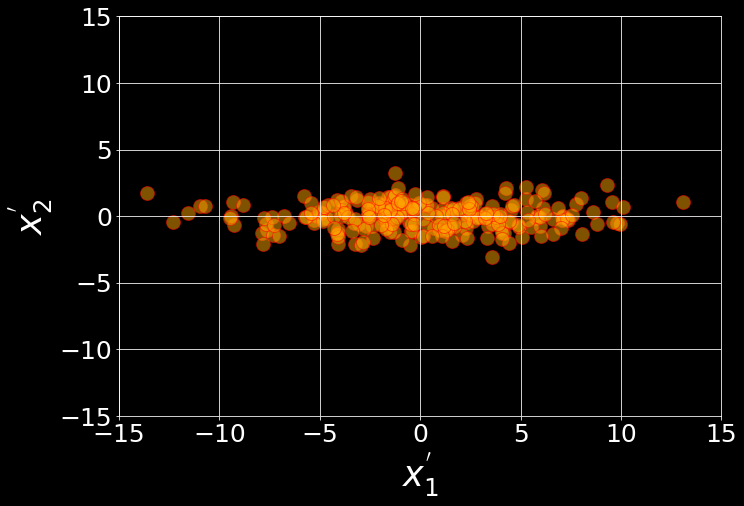

In [ ]:
X_new = pca.transform(X)

fig  = plt.figure(figsize=(10,7))

plt.scatter(X_new[:, 0],X_new[:, 1],
            alpha = 0.5, s = 196,
            c = 'orange', edgecolor = 'r');
plt.grid()
plt.xlabel(r"$x^{'}_1$",fontsize=35)
plt.ylabel(r"$x^{'}_2$",fontsize=35)
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);
plt.tight_layout()
plt.xlim((-15,15))
plt.ylim((-15,15));

In [ ]:
Eigen_Vectors = pca.components
Eigen_Values = pca.values

Проверим, что полученные собственные вектора и собственные  значения действительно связаны с распределением исходных данных

Для этого выполним аффинное преобразование единичной окружности, используя собственные вектора для определения угла наклона эллипса, а собственные значения как характерный размер вдоль соответсвующей оси эллипса

In [ ]:
X_mean = np.mean(X, axis = 0)

theta_ = 2 * np.pi * np.arange(0,1,0.01)

X_std = Eigen_Vectors @ np.diag(np.sqrt(Eigen_Values)) @ np.array([np.cos(theta_),np.sin(theta_)])



"Теория" говорит о том, что полученный эллипс должен содержать в себе распределение 68% от всех точек (1 стандартное отклонение от среднего)

При этом если оси эллипса увеличить в два раза то в таком эллипсе будет 95% точек (2 стандартных оклонений от среднего)

Выполним визуализацию исходных данных, эллипсов полученыых из собственных значений и векторов, с поправкой на среднее значение, а также базис из главных компонент

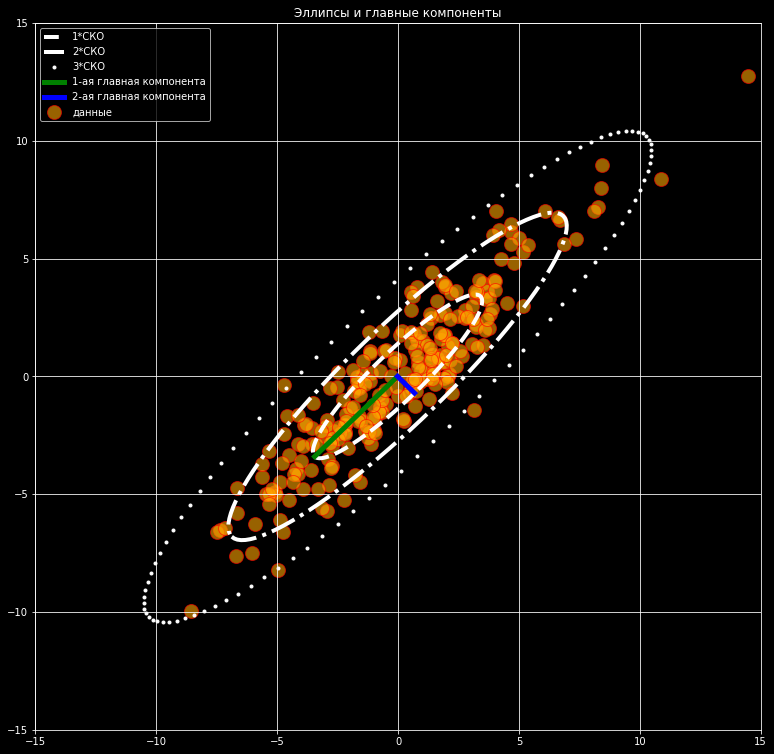

In [ ]:
fig = plt.figure(figsize=(13,13))
# рисуем данные
plt.scatter(X[:,0],X[:,1], alpha = 0.6, label = 'данные',s = 196, c = 'orange', edgecolor = 'r')
# рисуем эллипс с "диаметром" ~ 1*СКО
plt.plot(X_std[0,:]+X_mean[0],X_std[1,:]+X_mean[1],
         '--', c = 'w', linewidth = 4, label = '1*СКО')
#рисуем эллипс с "диаметром" ~ 2*СКО
plt.plot(2*X_std[0,:]+X_mean[0],2*X_std[1,:]+X_mean[1],
         '-.', c = 'w', linewidth = 4, label = '2*СКО')
#рисуем эллипс с "диаметром" ~ 3*СКО
plt.plot(3*X_std[0,:]+X_mean[0],3*X_std[1,:]+X_mean[1],
         '.', c = 'w', linewidth = 4, label = '3*СКО')
# 1-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,0]*np.sqrt(Eigen_Values[0])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,0]*np.sqrt(Eigen_Values[0])]),
         'g',linewidth = 5, label = '1-ая главная компонента')
# 2-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,1]*np.sqrt(Eigen_Values[1])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,1]*np.sqrt(Eigen_Values[1])]),
         'b',linewidth = 5, label = '2-ая главная компонента')
plt.xlim((-15,15))
plt.ylim((-15,15))
plt.title('Эллипсы и главные компоненты')
plt.legend()
plt.grid()


Вроде все совпадает с теорием

# Посмотрим на почти Реальных данных

In [ ]:
X, y  = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)
X = X / 255.
X_ = X.values

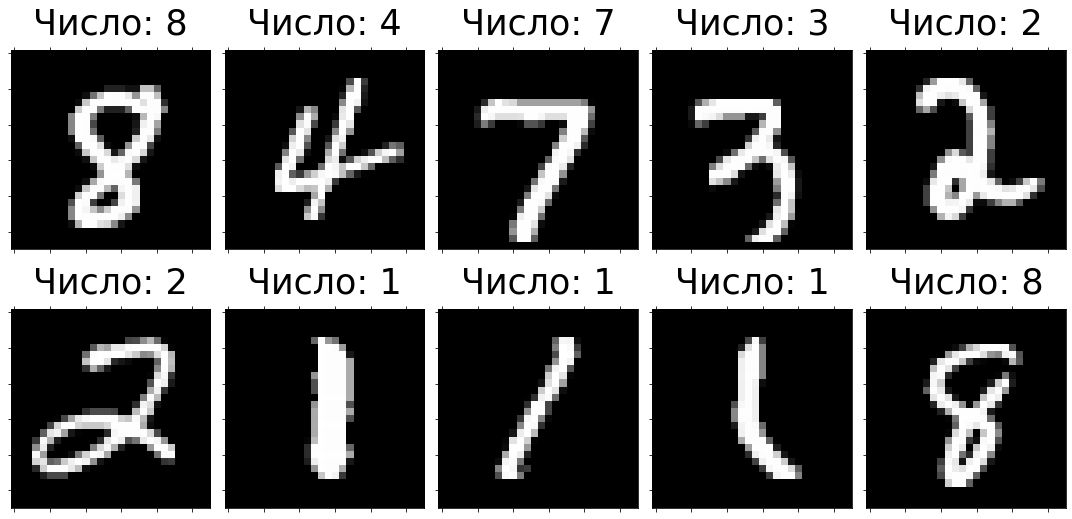

In [ ]:
#@title Разные примеры { run: "auto" }
n =  15258 #@param {type:"slider", min:1, max:69984, step:1}

fig = plt.figure( figsize=(15,8) )
for i in range(0,10):
  ax = fig.add_subplot(2,5,i+1)
  ax.set_title("Число: {}".format(str(y[i+n]) ), size=35)
  ax.matshow(1-X.loc[i+n,'pixel1':'pixel784'].values.reshape((28,28)).astype(float),
             cmap='Greys')
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
  plt.tight_layout()


# Применяем Метод Главных Компонент к Данным

In [ ]:
pca = PCA(n_components = 100)
pca.fit(X_)
pca.score(X_)

0.9398662110143557

In [ ]:
pca_result_mnist = pca.transform(X_)

In [ ]:
pca_inverse = pca.inverse_transform(pca_result_mnist)

In [ ]:
pca_inverse.shape

(70000, 784)

# Визуализация

Разная

**Собственные значения**

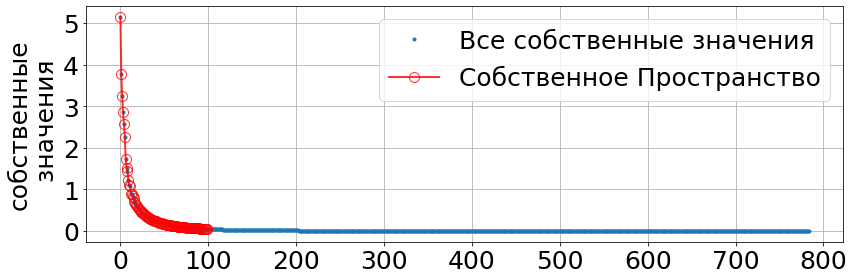

In [ ]:
pca.plot_eigvalues();

**Очень интересный график**

In [ ]:
def plot_multi(data, y,  names):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]


    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    fig, sub = plt.subplots(2, 2, figsize = (11,11))

    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = 36, cmap = 'tab10',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)
        ax.grid()
        ax.set_xlim([-10,12])
        ax.set_ylim([-8,8])
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Цифры",
                        fontsize = 15)
        ax.add_artist(legend1)

In [ ]:
pca_names = [str(x+1)+' Главная Компонента' for x in range(4)]

**Пространство Главных Компонент**

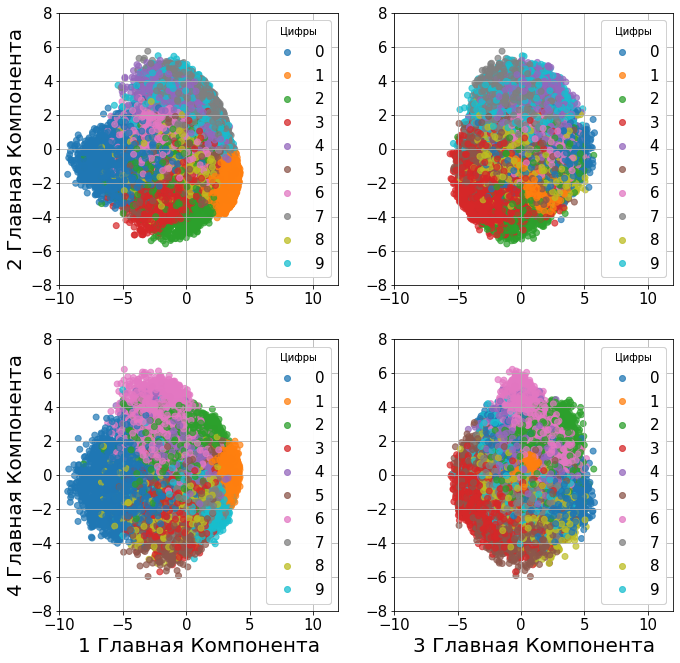

In [ ]:
plot_multi(pca_result_mnist, y.astype(int), pca_names);

# Восстановление данных

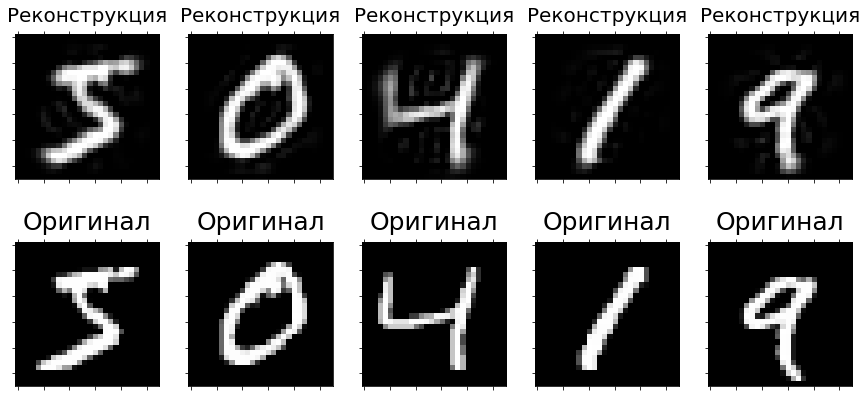

In [ ]:
fig=plt.figure(figsize=(15,7))
for i in range(0,5):
  ax = fig.add_subplot(2,5,i+1)
  ax.set_title("Реконструкция", size=20)
  ax.matshow(1-pca_inverse[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
  ax = fig.add_subplot(2,5,i+6)
  ax.set_title("Оригинал", size=25)
  ax.matshow(1-X_[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

plt.savefig('Рис5_6.png', dpi = 300,bbox_inches='tight');

# Попытка понять что значат главные компоненты

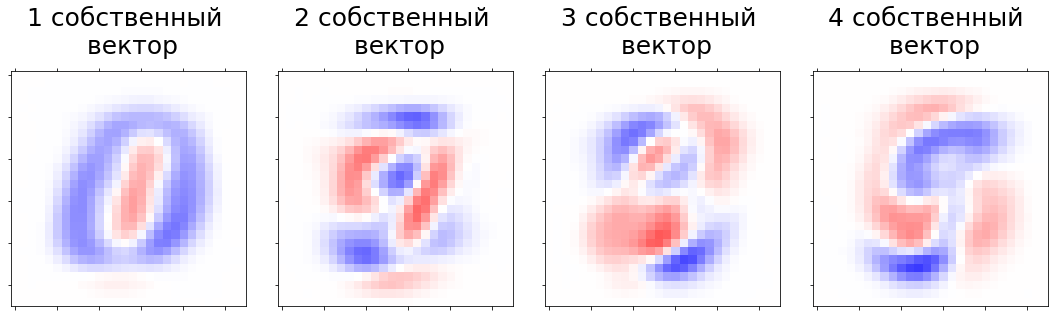

In [ ]:
W_pca=pca.components.T
fig=plt.figure(figsize=(15,5))
for i in range(0,4):
  ax = fig.add_subplot(1,4,i+1,title=str(i+1) )
  ax.set_title("{} собственный \n вектор".format(str(i+1)), size=25)
  ax.matshow(W_pca[i].reshape((28,28)).astype(float), cmap = 'bwr', vmin=-0.20,vmax = 0.20)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout();

In [ ]:
pca.values

array([ 5.14100825e+00,  3.77444717e+00,  3.24383475e+00,  2.85024769e+00,
        2.57887847e+00,  2.27097726e+00,  1.72926011e+00,  1.52426579e+00,
        1.45501790e+00,  1.23546262e+00,  1.11126353e+00,  1.07479514e+00,
        9.00464527e-01,  8.93583633e-01,  8.35223101e-01,  7.84036580e-01,
        6.95952413e-01,  6.74671108e-01,  6.26277966e-01,  6.08166078e-01,
        5.62328559e-01,  5.32659478e-01,  5.05945592e-01,  4.79826167e-01,
        4.65927643e-01,  4.42470761e-01,  4.27180629e-01,  4.14460717e-01,
        3.90483169e-01,  3.63977662e-01,  3.46111384e-01,  3.40481082e-01,
        3.16927996e-01,  3.08906116e-01,  2.98958554e-01,  2.86676987e-01,
        2.66234738e-01,  2.56931001e-01,  2.52645498e-01,  2.46652393e-01,
        2.39676286e-01,  2.34691151e-01,  2.20606342e-01,  2.08973701e-01,
        2.02403163e-01,  1.98223866e-01,  1.90649847e-01,  1.84108045e-01,
        1.78678561e-01,  1.68637502e-01,  1.67138292e-01,  1.63599280e-01,
        1.56391320e-01,  

In [ ]:
pca.components

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Контрольные вопросы

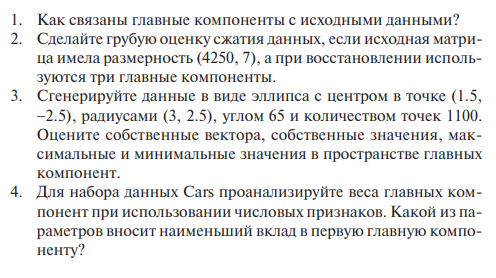

1.  Главные компоненты вносят основной
вклад в дисперсию исходных данных
2. 0.42 = 42%


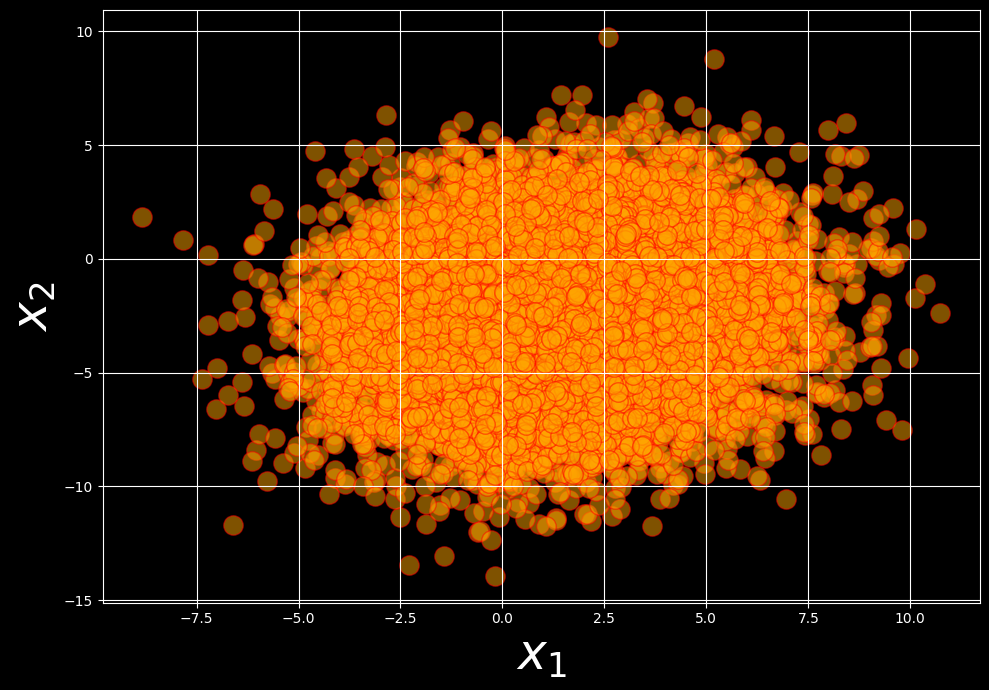

In [32]:
3.

def create_elipsoid_data(C1 = 1.5,C2 = -2.5 ,S1 = 3,S2 =2.5, theta =65, N = 11000, random_state = 42):
    np.random.seed(random_state)

    theta = np.pi*theta/180
    Centers = np.array([C1,C2])
    Sigmas = np.array([S1,S2])

    R = np.array([[np.cos(theta), - np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])

    return (R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers)@ np.ones((2, N))).T


X =create_elipsoid_data()


fig  = plt.figure(figsize=(10,7))
plt.scatter(X[:, 0],X[:, 1],
            alpha = 0.5, s = 196,
            c = 'orange', edgecolor = 'r');
plt.grid()

plt.xlabel(r'$x_1$',fontsize=35)
plt.ylabel(r'$x_2$',fontsize=35)
plt.tight_layout();

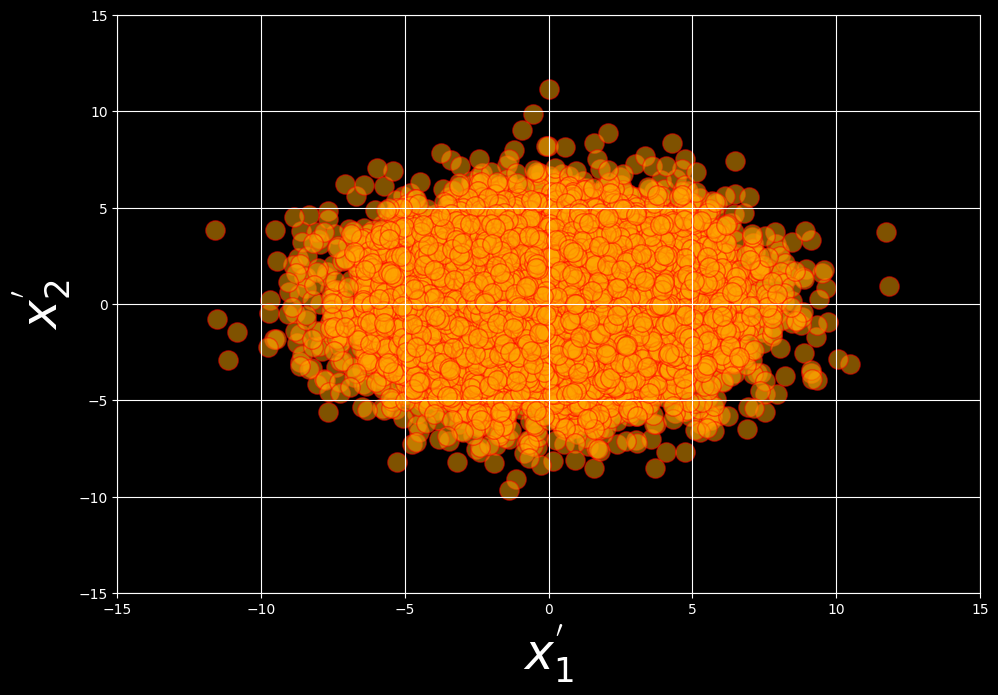

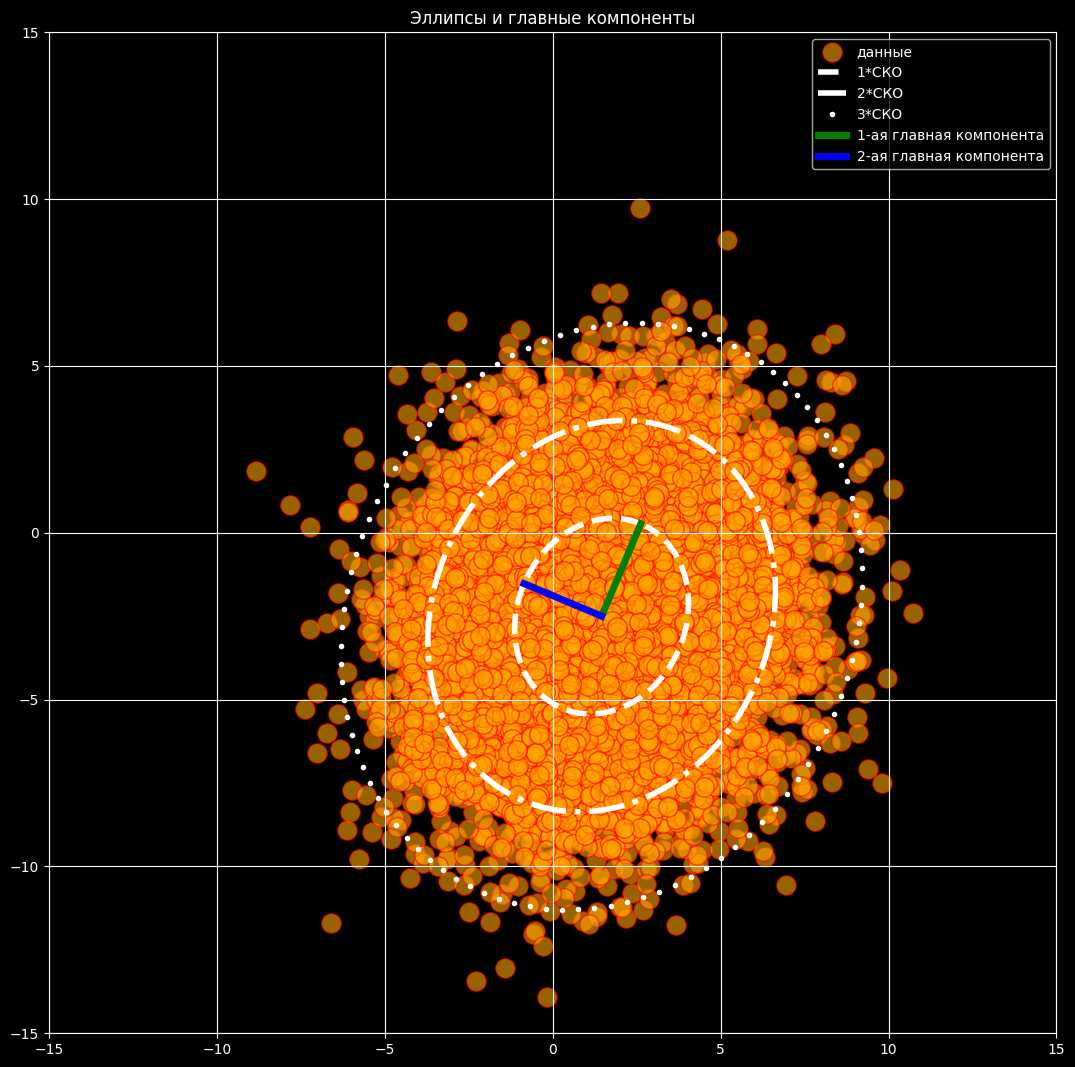

In [36]:

pca = PCA(n_components = 2)
pca.fit(X)
pca.score(X)

X_new = pca.transform(X)

fig  = plt.figure(figsize=(10,7))

plt.scatter(X_new[:, 0],X_new[:, 1],
            alpha = 0.5, s = 196,
            c = 'orange', edgecolor = 'r');
plt.grid()
plt.xlabel(r"$x^{'}_1$",fontsize=35)
plt.ylabel(r"$x^{'}_2$",fontsize=35)
plt.tight_layout()
plt.xlim((-15,15))
plt.ylim((-15,15));

Eigen_Vectors = pca.components
Eigen_Values = pca.values

X_mean = np.mean(X, axis = 0)

theta_ = 2 * np.pi * np.arange(0,1,0.01)

X_std = Eigen_Vectors @ np.diag(np.sqrt(Eigen_Values)) @ np.array([np.cos(theta_),np.sin(theta_)])

fig = plt.figure(figsize=(13,13))
# рисуем данные
plt.scatter(X[:,0],X[:,1], alpha = 0.6, label = 'данные',s = 196, c = 'orange', edgecolor = 'r')
# рисуем эллипс с "диаметром" ~ 1*СКО
plt.plot(X_std[0,:]+X_mean[0],X_std[1,:]+X_mean[1],
         '--', c = 'w', linewidth = 4, label = '1*СКО')
#рисуем эллипс с "диаметром" ~ 2*СКО
plt.plot(2*X_std[0,:]+X_mean[0],2*X_std[1,:]+X_mean[1],
         '-.', c = 'w', linewidth = 4, label = '2*СКО')
#рисуем эллипс с "диаметром" ~ 3*СКО
plt.plot(3*X_std[0,:]+X_mean[0],3*X_std[1,:]+X_mean[1],
         '.', c = 'w', linewidth = 4, label = '3*СКО')
# 1-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,0]*np.sqrt(Eigen_Values[0])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,0]*np.sqrt(Eigen_Values[0])]),
         'g',linewidth = 5, label = '1-ая главная компонента')
# 2-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,1]*np.sqrt(Eigen_Values[1])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,1]*np.sqrt(Eigen_Values[1])]),
         'b',linewidth = 5, label = '2-ая главная компонента')
plt.xlim((-15,15))
plt.ylim((-15,15))
plt.title('Эллипсы и главные компоненты')
plt.legend()
plt.grid()

4. Transmission